In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper', style='ticks', color_codes=True)

import numpy as np
import pandas as pd
import scipy
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

Load the results of the regression on all compounds

In [2]:
ysi = pd.read_csv('ysi.csv')
fragments = pd.read_csv('fragments.csv', index_col=0)
fitted_fragments= pd.read_pickle('data/fragment_regression.p')

This is some complicated MPL code to just do the signed square-root axis

In [3]:
import matplotlib.scale as mscale
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import matplotlib.ticker as ticker
import numpy as np

class SqRootScale(mscale.ScaleBase):
    """
    ScaleBase class for generating sq root scale.
    """

    name = 'sqroot'

    def __init__(self, axis, **kwargs):
        mscale.ScaleBase.__init__(self)

    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(ticker.AutoLocator())
        axis.set_major_formatter(ticker.ScalarFormatter())
        axis.set_minor_locator(ticker.NullLocator())
        axis.set_minor_formatter(ticker.NullFormatter())

    class SqRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform_non_affine(self, a): 
            return np.sign(a) * np.sqrt(np.abs(a))

        def inverted(self):
            return SqRootScale.InvertedSqRootTransform()

    class InvertedSqRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform(self, a):
            return np.sign(a) * np.array(a)**2 

        def inverted(self):
            return SqRootScale.SqRootTransform()

    def get_transform(self):
        return self.SqRootTransform()

mscale.register_scale(SqRootScale)

In [4]:
from pymc3 import hpd

fragment_counts = (fragments != 0).sum(0)

frag_means = fitted_fragments.iloc[:,1:].median()
frag_hpd = fitted_fragments.iloc[:,1:].apply(lambda x: hpd(x).tolist(), 0)

frag_summary = pd.concat([fragment_counts, frag_means, frag_hpd], 1)
frag_summary.columns = ['Count', 'Median', 'Hpd']
frag_summary = frag_summary.sort_values('Median')

frag_summary['ring'] = frag_summary.index.str.contains('Ring')
frag_summary['oxygenate'] = frag_summary.index.str.contains('O')
frag_summary['aromatic'] = frag_summary.index.str.contains('c')

frag_summary.to_csv('data/frag_summary.csv', index_label='SMARTS')

yerr = np.vstack(frag_summary.Hpd.values)

yerr = yerr - frag_summary.Median.values[:, np.newaxis]

frag_summary['low_err'] = -yerr[:,0]
frag_summary['high_err'] = yerr[:,1]

frag_summary = frag_summary.reset_index()

In [5]:
def get_color(x):
    if x.oxygenate:
        return 'r'
    elif x.aromatic:
        return 'g'
    else:
        return 'b'

def get_marker(x):
    if x.ring:
        return 'o'
    else:
        return 's'
    
frag_summary['color'] = frag_summary.apply(get_color, 1)
frag_summary['marker'] = frag_summary.apply(get_marker, 1)

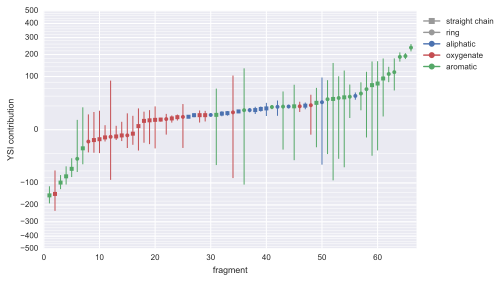

In [6]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(1)

ax.set_yscale('sqroot')
for index, fragment in frag_summary.iterrows():
    ax.errorbar(index + 1, fragment.Median,
            yerr=np.atleast_2d(fragment.loc[['low_err', 'high_err']].values),
            ls='', marker=fragment.marker, ms=4, elinewidth=1, color=fragment.color)    

#plt.show
ax.set_yticks(np.arange(-500, 501, 100))
out = ax.set_yticks(np.arange(-500, 501, 20), minor=True)

ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

ax.set_xlabel('fragment')
ax.set_ylabel('YSI contribution')


import matplotlib.lines as mlines
square = mlines.Line2D([], [], color='0.6', marker='s', markersize=6, ls='-', label='straight chain')
circle = mlines.Line2D([], [], color='0.6', marker='o', markersize=6, ls='-', label='ring')
blue = mlines.Line2D([], [], color='b', marker='o', markersize=6, ls='-', label='aliphatic')
red = mlines.Line2D([], [], color='r', marker='o', markersize=6, ls='-', label='oxygenate')
green = mlines.Line2D([], [], color='g', marker='o', markersize=6, ls='-', label='aromatic')

ax.set_xlim([0, frag_summary.shape[0]+1])

leg = ax.legend(loc='upper left', handles=[square, circle, blue, red, green], bbox_to_anchor=([1, 1]))

fig.tight_layout()
fig.savefig('figures/fragment_contribution.svg', bbox_extra_artists=[leg,], bbox_inches='tight')

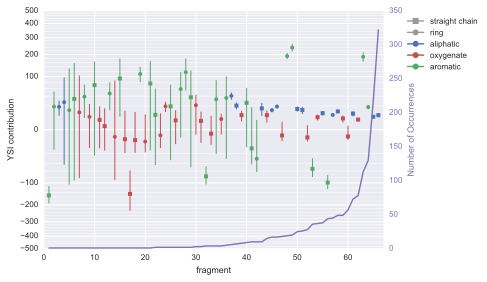

In [7]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(1)
    ax2 = ax.twinx()
    ax2.grid('off')

ax.set_yscale('sqroot')
for index, fragment in frag_summary.sort_values('Count').reset_index(drop=True).iterrows():
    ax.errorbar(index + 1, fragment.Median,
            yerr=np.atleast_2d(fragment.loc[['low_err', 'high_err']].values),
            ls='', marker=fragment.marker, ms=4, elinewidth=1, color=fragment.color)    

#plt.show
ax.set_yticks(np.arange(-500, 501, 100))
out = ax.set_yticks(np.arange(-500, 501, 20), minor=True)

ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)

ax.set_xlabel('fragment')
ax.set_ylabel('YSI contribution')

ax2.plot(range(1, len(frag_summary)+1),
         frag_summary.sort_values('Count').reset_index(drop=True).Count,
         color=sns.color_palette()[3])

ax2.tick_params('y', colors=sns.color_palette()[3])
ax2.set_ylabel('Number of Occurrences', color=sns.color_palette()[3])

square = mlines.Line2D([], [], color='0.6', marker='s', markersize=6, ls='-', label='straight chain')
circle = mlines.Line2D([], [], color='0.6', marker='o', markersize=6, ls='-', label='ring')
blue = mlines.Line2D([], [], color='b', marker='o', markersize=6, ls='-', label='aliphatic')
red = mlines.Line2D([], [], color='r', marker='o', markersize=6, ls='-', label='oxygenate')
green = mlines.Line2D([], [], color='g', marker='o', markersize=6, ls='-', label='aromatic')

ax.set_xlim([0, frag_summary.shape[0]+1])

leg = ax.legend(loc='upper left', handles=[square, circle, blue, red, green], bbox_to_anchor=([1.05, 1]))

fig.tight_layout()
fig.savefig('figures/fragment_contribution_by_count.svg', bbox_extra_artists=[leg,], bbox_inches='tight')